In [12]:
# 1. Load & QC LAS File

import lasio
import pandas as pd
import matplotlib.pyplot as plt
las = lasio.read("ALTHORPE 1_MAIN_HR_Althorpe.las")

# Convert to DataFrame
df = las.df()
df.index.name = 'Depth'

# Check available curves
print("Available curves:", list(df.columns))
df.head()

Available curves: ['CGXT', 'SMTU', 'GRGC', 'CCLG', 'FEFE', 'FEFR', 'NPOR', 'NPRL', 'NPRS', 'NPRD', 'CLDC', 'DENF', 'DENN', 'DCOR', 'DEN', 'PDPE', 'DPOR', 'DPRL', 'DPRS', 'DPRD', 'TR21', 'TR11', 'TR22', 'TR12', 'DT35', 'CLYC', 'DSLL', 'DDLL', 'DGLL', 'HVOL', 'AVOL', 'BIT']


,CGXT,SMTU,GRGC,CCLG,FEFE,FEFR,NPOR,NPRL,NPRS,NPRD,...,TR22,TR12,DT35,CLYC,DSLL,DDLL,DGLL,HVOL,AVOL,BIT
Depth,,,,,,,,,,,,,,,,,,,,,
4319.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4318.917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5
4318.834,NaN,1444.141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,413.246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5
4318.751,NaN,1441.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,413.230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5
4318.668,NaN,1455.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,413.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5


In [13]:
# Simple way to check which parameters available in the LAS file
print(las.curves.keys())

['DEPT', 'CGXT', 'SMTU', 'GRGC', 'CCLG', 'FEFE', 'FEFR', 'NPOR', 'NPRL', 'NPRS', 'NPRD', 'CLDC', 'DENF', 'DENN', 'DCOR', 'DEN', 'PDPE', 'DPOR', 'DPRL', 'DPRS', 'DPRD', 'TR21', 'TR11', 'TR22', 'TR12', 'DT35', 'CLYC', 'DSLL', 'DDLL', 'DGLL', 'HVOL', 'AVOL', 'BIT']


In [ ]:
# 3. Rename Key Curves (alis matching)

curve_aliases = {
    'GR': 'GRGC',           # Gamma Ray
    'RHOB': 'DEN',          # Density
    'PEF': 'PDPE',          # Photoelectric
    'Caliper': 'CLDC',      # Borehole Diameter
    'DPOR': 'DPOR',         # Density Porosity
    'NPOR': 'NPOR',         # Neitron Porosity
    'RES': 'DDLL',          # Deep Resistivity
}

# Filter columns that exist & rename for consistency
available = [alias for alias in curve_aliases.values() if alias in df.columns]
df = df[available]

# (Optional) Check for missing expected logs
missing = [v for v in curve_aliases.values() if v not in df.columns]
if missing:
    print(f" Warning:💥 Missing Curves from LAS File: {missing}")
    
# Rename to standard curves names (GR, RHOB, etc.)
df = df.rename(columns={v: k for k, v in curve_aliases.items()})

df.dropna(how='all', inplace=True)

In [15]:
# 4. Coal Zone Criteria & Zonation
# Define criteria for Coal

required_cols = ['GR', 'RHOB', 'PEF', 'DPOR', 'NPOR']
if all(col in df.columns for col in required_cols):
    criteria = (
        (df['GR'] < 50) &
        (df['RHOB'] < 1.8) &
        (df['PEF'] < 1.5) &
        (df['DPOR'] > 0.04) | (df['NPOR'] > 0.04)
    )
    df['is coal'] = criteria.astype(int)
else:
    print("🔰 Not all required logs are available to define coal zone")

In [ ]:
# 5. Group Coal Intervals + Thickness

from itertools import groupby
from operator import itemgetter

coal_depths = df[criteria].index.to_list()      # Cari semua depth yang memenuhi syarat Coal
coal_intervals = []                             # space to keep the data

for k, g in groupby(enumerate(coal_depths), lambda x: x[0] - x[1]):     # groupby(...) - pisahkan coal_depths kepada kumpulan depth yang bersambung
    group = list(map(itemgetter(1), g))     # ambil semua depth sahaja, buang index
    top = min(group)
    base = max(group)
    thickness = base - top      # calculate thickness coal
    if thickness > 0.5:         # Filter thin beds if needed (hanya consider coal zone yang lebih tebal dari 0.5ft)
        coal_intervals.append({'Top(ft)': top, 'Base(ft)': base, 'Thickness(ft)': thickness})
        
    coal_df = pd.DataFrame(coal_intervals)      # simpan semua dalam dataframe
    coal_df

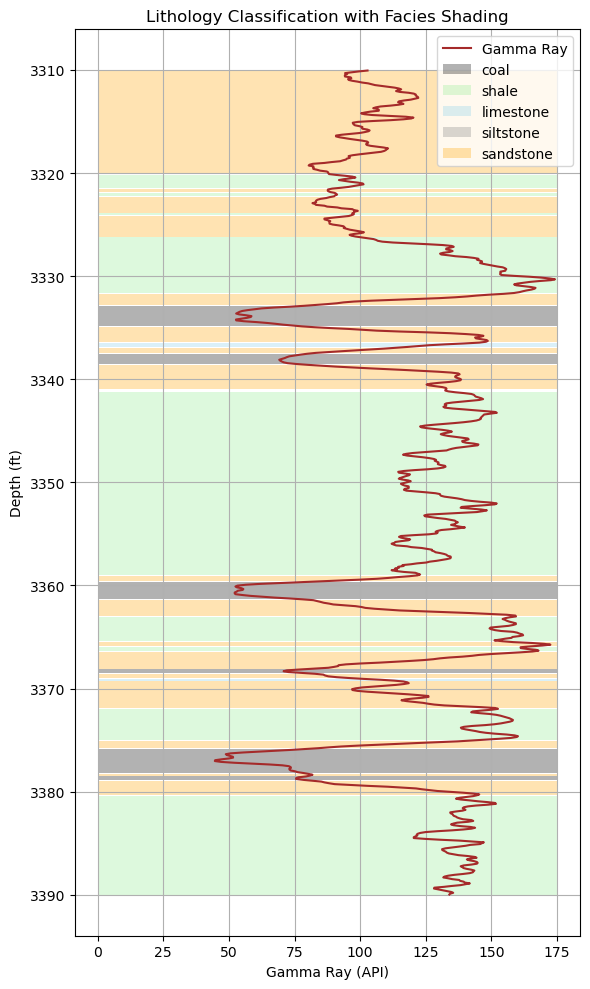

In [ ]:
# 6. Classify Lithology with Facies Shading

df = df.copy()
df.index.name = 'Depth'

# Subset depth range from composite log
df = df[(df.index >= 3310) & (df.index <= 3390)]

def classify_lithology(row):
    # Coal
    if row['GR'] < 80 and row['RHOB'] < 1.9 and row['PEF'] < 2.0:
        return 'coal'
    
    # Shale
    elif row['GR'] > 90 and row['RHOB'] > 2.5:
        return 'shale'
    
    # Limestone
    elif row['RHOB'] < 2.4 and row['PEF'] > 3.2:
        return 'limestone'
    
    # Siltstone
    elif 60 < row['GR'] < 90 and 2.4 <= row['RHOB'] <= 2.6 and row['NPOR'] < 0.2:
        return 'siltstone'
    
    # Default fallback
    else:
        return 'sandstone'
    
df['Facies'] = df.apply(classify_lithology, axis=1)

# Define color map for lithologies
import matplotlib.pyplot as plt

# Define the colors for each facies
facies_colors = {
    'coal': 'black',
    'shale': 'lightgreen',
    'limestone': 'skyblue',
    'siltstone': 'grey',
    'sandstone': 'orange'
}

# Plotting
plt.figure(figsize=(6,10))
plt.plot(df['GR'], df.index, label='Gamma Ray', color='brown')  # Or RHOB/log of choice

# Add shade to the facies
for facies, color in facies_colors.items():
    mask = df['Facies'] == facies
    plt.fill_betweenx(
        df.index,
        x1=0, x2=175,                                           # span full GR scale (adjust as needed)
        where=mask,
        facecolor=color,
        alpha=0.3,
        label=facies
    )
    
plt.gca().invert_yaxis()
plt.xlabel("Gamma Ray (API)")
plt.ylabel("Depth (ft)")
plt.title("Lithology Classification with Facies Shading")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

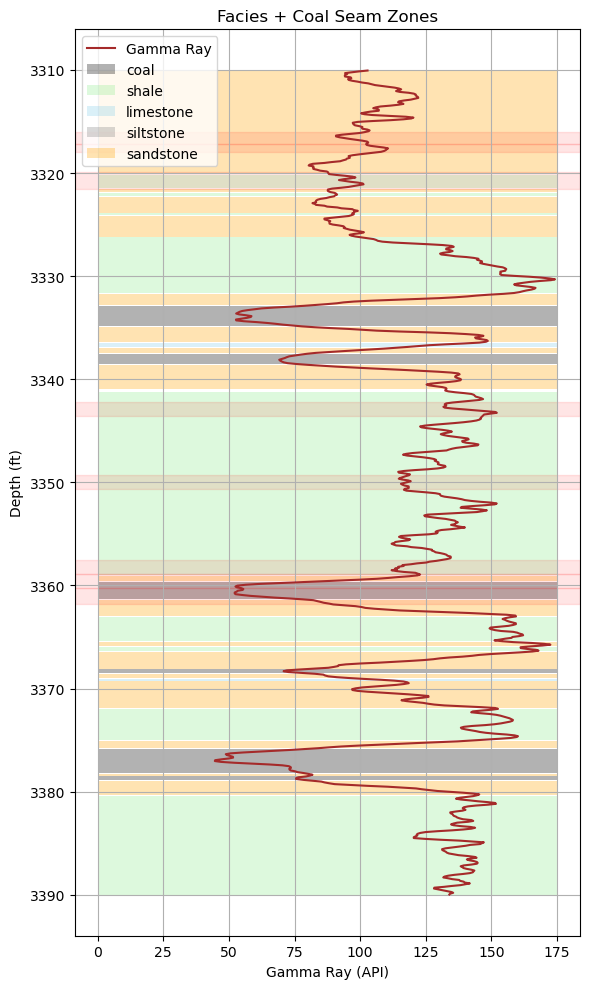

In [ ]:
# 7. Adding gas content shading to the plot

# Define the colors for each facies
facies_colors = {
    'coal': 'black',
    'shale': 'lightgreen',
    'limestone': 'skyblue',
    'siltstone': 'grey',
    'sandstone': 'orange'
}

# Plotting
plt.figure(figsize=(6,10))
plt.plot(df['GR'], df.index, label='Gamma Ray', color='brown')  # Or RHOB/log of choice

# Add shade to the facies
for facies, color in facies_colors.items():
    mask = df['Facies'] == facies
    plt.fill_betweenx(
        df.index,
        x1=0, x2=175,                                           # span full GR scale (adjust as needed)
        where=mask,
        facecolor=color,
        alpha=0.3,
        label=facies
    )

# Original gas sample data (based on geological report/ GL)
gas_samples = [
    {"Sample": "AT-1/13", "Top": 3315.97, "Base": 3317.22, "Gas": 137.77},
    {"Sample": "AT-1/14", "Top": 3317.22, "Base": 3317.97, "Gas": 129.89},
    {"Sample": "AT-1/15", "Top": 3319.88, "Base": 3321.59, "Gas": 130.27},
    {"Sample": "AT-1/16", "Top": 3342.23, "Base": 3343.61, "Gas": 162.13},
    {"Sample": "AT-1/17", "Top": 3349.28, "Base": 3350.69, "Gas": 132.86},
    {"Sample": "AT-1/18", "Top": 3357.49, "Base": 3358.87, "Gas": 125.01},
    {"Sample": "AT-1/19", "Top": 3358.87, "Base": 3360.28, "Gas": 121.98},
    {"Sample": "AT-1/20", "Top": 3360.28, "Base": 3361.76, "Gas": 114.43},
]

gc_df = pd.DataFrame(gas_samples)
gc_df["Midpoint"] = (gc_df["Top"] + gc_df["Base"]) / 2          # Depth for plotting - guna midpoint (most accurate and standard method)

# Shading for the seam
for seam in gas_samples:
    plt.axhspan(seam["Top"], seam["Base"], color='red', alpha=0.1)      # axis horizontal span (axhspan) - to color the horizontal line/axis
    
plt.gca().invert_yaxis()
plt.xlabel("Gamma Ray (API)")
plt.ylabel("Depth (ft)")
plt.title("Facies + Coal Seam Zones")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

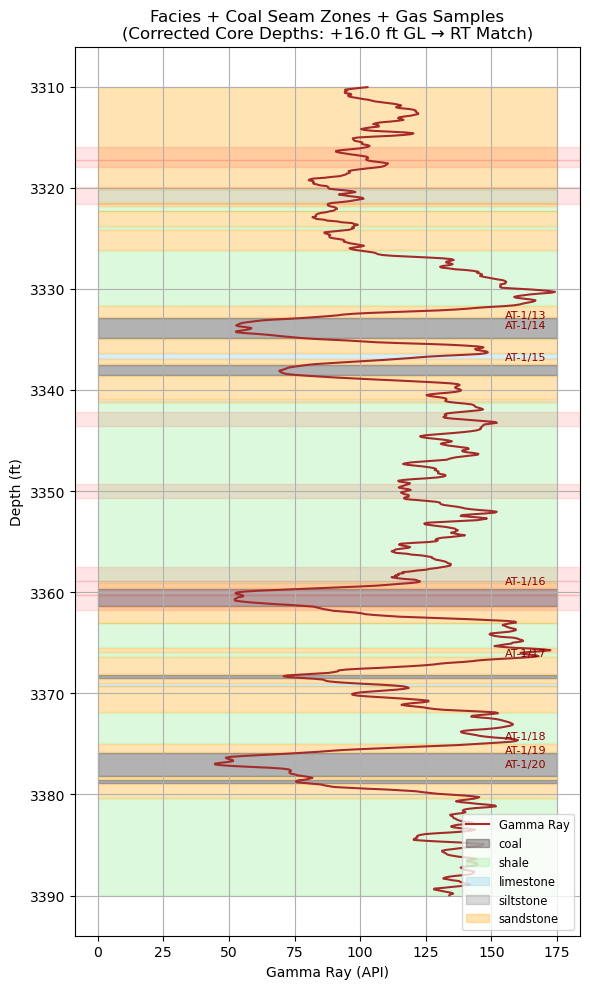

In [25]:
# 8. Adding gas content shading to the plot with labeling

import pandas as pd

# Define the colors for each facies
facies_colors = {
    'coal': 'black',
    'shale': 'lightgreen',
    'limestone': 'skyblue',
    'siltstone': 'grey',
    'sandstone': 'orange'
}

# Plotting
plt.figure(figsize=(6,10))
plt.plot(df['GR'], df.index, label='Gamma Ray', color='brown')  # Or RHOB/log of choice

# Add shade to the facies
used_labels = set()
for facies, color in facies_colors.items():
    mask = df['Facies'] == facies
    label = facies if facies not in used_labels else None
    plt.fill_betweenx(
        df.index,
        x1=0, x2=175,                                           # span full GR scale (adjust as needed)
        where=mask,
        color=color,
        alpha=0.3,
        label=label
    )

# Original gas sample data (based on geological report/ GL)
gas_samples = [
    {"Sample": "AT-1/13", "Top": 3315.97, "Base": 3317.22, "Gas": 137.77},
    {"Sample": "AT-1/14", "Top": 3317.22, "Base": 3317.97, "Gas": 129.89},
    {"Sample": "AT-1/15", "Top": 3319.88, "Base": 3321.59, "Gas": 130.27},
    {"Sample": "AT-1/16", "Top": 3342.23, "Base": 3343.61, "Gas": 162.13},
    {"Sample": "AT-1/17", "Top": 3349.28, "Base": 3350.69, "Gas": 132.86},
    {"Sample": "AT-1/18", "Top": 3357.49, "Base": 3358.87, "Gas": 125.01},
    {"Sample": "AT-1/19", "Top": 3358.87, "Base": 3360.28, "Gas": 121.98},
    {"Sample": "AT-1/20", "Top": 3360.28, "Base": 3361.76, "Gas": 114.43},
]

# Adjust to Composite Log Depth (from GL to RT)
gc_df = pd.DataFrame(gas_samples)
depth_shift = 16.0  # Approx shift from GL to RT
gc_df["Top"] += depth_shift
gc_df["Base"] += depth_shift
gc_df["Midpoint"] = (gc_df["Top"] + gc_df["Base"]) / 2    

# Shading for the seam
for seam in gas_samples:
    plt.axhspan(seam["Top"], seam["Base"], color='red', alpha=0.1)
    
# Sample labels
for i, row in gc_df.iterrows():
    plt.text(155, row["Midpoint"], row["Sample"], fontsize=8, color='darkred', va='center')      
    
plt.gca().invert_yaxis()
plt.xlabel("Gamma Ray (API)")
plt.ylabel("Depth (ft)")
plt.title("Facies + Coal Seam Zones + Gas Samples\n(Corrected Core Depths: +16.0 ft GL → RT Match)")
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
